# Global Wikipedia & Education User Group


This notebook is for Wikipedia & Education User Group across all languages/projects between July 1, 2019 - June 30, 2020
https://phabricator.wikimedia.org/T260369

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import glob
import re
import xlrd
from wmfdata import hive,charting,spark
from wmfdata.charting import comma_fmt, pct_fmt
from wmfdata.utils import pct_str


You are using wmfdata v1.0.3, but v1.0.4 is available.

To update, run `pip install --upgrade git+https://github.com/neilpquinn/wmfdata.git@release`.

To see the changes, refer to https://github.com/neilpquinn/wmfdata/blob/release/CHANGELOG.md


In [2]:
%matplotlib inline

charting.set_mpl_style()


# Getting a list of participants into Hive

In [23]:
#read usernames from CSV
csv_files = glob.glob('*.csv')
#intialize empty list that we will append dataframes to
list_data = []
 
for filename in csv_files:
    data = pd.read_csv(filename,header=None)
    list_data.append(data)

participants = pd.concat(list_data,ignore_index=True)

In [25]:
#read usernames from excel
roster = pd.read_excel('usernames-education.xlsx', header=None)

In [26]:
participants = participants.append(roster)

In [32]:
filepath = "global-wiki-education-foundation-participants.csv"
participants.to_csv(filepath, index=None)
hive.load_csv(
    filepath,
    field_spec="user_name string",
    db_name="cchen",
    table_name="global_wiki_education_foundation_participants",
)

# New active editors

In [17]:
new_active_editors_r = spark.run("""

select
    cohort,
    sum(cast(wefp.user_name is not null as int)) as wef_new_users,
    sum(cast(wefp.user_name is null as int)) as non_wef_new_users
from cchen.new_editor_retention ne
left join cchen.global_wiki_education_foundation_participants wefp 
on ne.user_name = wefp.user_name
where 1st_month_edits >= 5
group by cohort, wiki

"""
)

new_active_editors = (
    new_active_editors_r
    .assign(
        cohort=lambda df: pd.to_datetime(df["cohort"])
    )
)

In [21]:
(
    new_active_editors
    .query("cohort >= '2019-07-01'")
    .groupby("cohort").agg({
        "wef_new_users": "sum"
    })
    
)

,wef_new_users
cohort,
2019-07-01,746
2019-08-01,1954
2019-09-01,5534
2019-10-01,2414
2019-11-01,978
2019-12-01,168
2020-01-01,4240
2020-02-01,3064
2020-03-01,1612


In [22]:
(
    new_active_editors
    .query("cohort >= '2019-07-01'")
    .agg({
        "wef_new_users": "sum"
    })
    .div(12)
    .apply(round)
)

wef_new_users    1887
dtype: int64

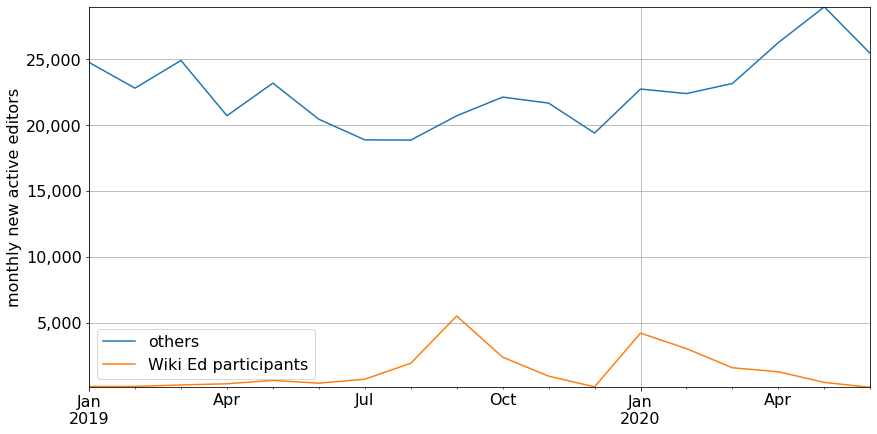

In [23]:
global_new_active_editors = new_active_editors.query("cohort >= '2019-01-01'").groupby("cohort").sum().iloc[:, [1, 0]]
global_new_active_editors.columns = ["others", "Wiki Ed participants"]
ax = global_new_active_editors.plot()
ax.set_ylabel("monthly new active editors")
ax.set_xlabel("")
ax.yaxis.set_major_formatter(comma_fmt);